# CoRaLS Monte Carlo acceptance model 

This will step through a the main Monte Carlo model and plot some results.

In [1]:
# Import and compile modules - slow the first time you run on a fresh kernel
using Printf
using CoRaLS
using ProgressMeter
using PyPlot
using LaTeXStrings
using DelimitedFiles
using Unitful: km, sr, EeV, MHz, m, μV, cm, ustrip

In [2]:
# Number of trials and energy bins in each run
ntrials = 10000  # Baseline test: 100_000
nbins = 10  # Baseline test: 20

altitude = 40km
ice_depth = 6.0m

# Acceptance run (adapted from test/study_tests.jl)
A = acceptance( ntrials, nbins; 
                altitude=altitude, 
                ice_depth=ice_depth,
                min_energy=1.0EeV,
                ν_max=1000MHz,
                dν = 30MHz,
                trigger=gaussian_trigger(sqrt(1000 / 300.)*0.5*67μV/m),
                save_events=true, orbit=false)

E_bins = 18.0 .+ log10.(0.5*(A.energies[1:end-1] + A.energies[2:end]) / 1.0EeV)
A_direct = A.dAΩ / 1km^2 / 1sr
A_reflected = A.rAΩ / 1km^2 / 1sr;  # semicolon suppresses output

┌ Info: Calculating acceptance using 10000 trials across 10 bins...
└ @ CoRaLS /home/cjtu/projects/CoRaLS.jl/src/acceptance.jl:56
Simulating... 100%|██████████████████████████████████████| Time: 0:00:18


In [3]:
println("Nvisible: ", size(A.reflected)[1])
dtrig = [t for t in A.direct if t.triggered]
rtrig = [t for t in A.reflected if t.triggered]
println(size(dtrig), dtrig)
println(size(rtrig), rtrig)
Emax = sort([maximum(ustrip.(e.Ef)) for e in rtrig])

Nvisible: 42188
(128,)CoRaLS.Direct[DirectEvent(4.416179524271415 EeV, -16.179166568867977), DirectEvent(10.820929591980665 EeV, -18.749034480561306), DirectEvent(11.52561334305289 EeV, -12.887526424354505), DirectEvent(6.87312453746663 EeV, -31.71032458604666), DirectEvent(19.8335028137462 EeV, -18.9592122248397), DirectEvent(17.51710932589708 EeV, -15.845914915060055), DirectEvent(16.18785769924307 EeV, -18.57910398134257), DirectEvent(43.50674044370142 EeV, -21.288128634441733), DirectEvent(29.325581719974338 EeV, -41.9462965542174), DirectEvent(75.39976558270605 EeV, -46.31986380064959), DirectEvent(75.68494393860705 EeV, -26.31250894958507), DirectEvent(53.370654007965 EeV, -23.511414751303548), DirectEvent(64.19964898448968 EeV, -24.9422928339061), DirectEvent(51.44930549962304 EeV, -19.009698172884306), DirectEvent(51.251852042579046 EeV, -16.284502897676493), DirectEvent(73.95775175658076 EeV, -13.911903097089478), DirectEvent(48.175633307057 EeV, -22.733926582537535), DirectEv

2420-element Vector{Float64}:
   1.160643586841931
   1.701817688481511
   1.8339543083690844
   1.8357968611437163
   1.8495999955645765
   1.8535024414412247
   1.8783423290543848
   1.9291205951994388
   1.9299213784018983
   2.0008508018054307
   ⋮
 168.7818569109452
 174.04070436757166
 185.2102843954392
 198.59974405397008
 210.8206079818688
 235.12910278419514
 239.02220170505203
 241.8367009745774
 273.9531928954309

In [20]:
# Number of trials and energy bins in each run
ntrials = 500000  # Baseline test: 100_000
nbins = 10  # Baseline test: 20

B = acceptance( ntrials, nbins; 
                altitude=altitude, 
                ice_depth=ice_depth,
                min_energy=1.0EeV,
                ν_max=1000MHz,
                dν = 30MHz,
                trigger=gaussian_trigger(sqrt(1000 / 300.)*0.5*67μV/m),
                save_events=true, orbit=true)


┌ Info: Calculating acceptance using 500000 trials across 10 bins...
└ @ CoRaLS /home/cjtu/projects/CoRaLS.jl/src/acceptance.jl:56
Simulating... 100%|██████████████████████████████████████| Time: 0:00:20


CoRaLS.Acceptance(500000, 40 km, Unitful.Quantity{Float64, 𝐋^2, Unitful.FreeUnits{(km^2, sr), 𝐋^2, nothing}}[1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr], Unitful.Quantity{Float64, 𝐋^2 𝐌 𝐓^-2, Unitful.FreeUnits{(EeV,), 𝐋^2 𝐌 𝐓^-2, nothing}}[1.0 EeV, 1.8958986836690466 EeV, 3.5944318187380233 EeV, 6.814678553683553 EeV, 12.919940099556333 EeV, 24.494897427831773 EeV, 46.439843790034566 EeV, 88.0452387113227 EeV, 166.92485217612372 EeV, 316.47260751236286 EeV, 599.9999999999997 EeV], Unitful.Quantity{Float64, 𝐋^2, Unitful.FreeUnits{(km^2, sr), 𝐋^2, nothing}}[0.0 km^2 sr, 0.0 km^2 sr, 0.0 km^2 sr, 238.33584658114268 km^2 sr, 1906.6867726491414 km^2 sr, 953.3433863245707 km^2 sr, 2383.3584658114273 km^2 sr, 5005.052778203996 km^2 sr, 6673.

In [21]:
println("Nvisible: ", size(B.reflected)[1])
dtrig = [t for t in B.direct if t.triggered]
rtrig = [t for t in B.reflected if t.triggered]
println(size(dtrig), dtrig)
println(size(rtrig), rtrig)
Emax = sort([maximum(ustrip.(e.Ef)) for e in rtrig])

Nvisible: 45568
(122,)CoRaLS.Direct[DirectEvent(7.644946746581523 EeV, -29.935175109834095), DirectEvent(21.300974037733013 EeV, -16.821973284385138), DirectEvent(14.756999968160152 EeV, -17.193054857258975), DirectEvent(21.536853015830616 EeV, -13.110916928192564), DirectEvent(15.10852142861086 EeV, -34.33639814644053), DirectEvent(15.805421141573362 EeV, -21.492221562685277), DirectEvent(22.049501707503186 EeV, -32.220067271862966), DirectEvent(14.716300664512373 EeV, -37.1106743294373), DirectEvent(14.822064204193218 EeV, -15.04284420916426), DirectEvent(33.68182460369213 EeV, -18.094879926942635), DirectEvent(25.86564091168716 EeV, -17.03809920009003), DirectEvent(33.926775516287925 EeV, -13.393000605398559), DirectEvent(29.513752025405118 EeV, -12.97650913182891), DirectEvent(48.61016119830681 EeV, -12.930138185798548), DirectEvent(46.61400938989268 EeV, -17.178771334080032), DirectEvent(52.66304248642089 EeV, -17.52460230703195), DirectEvent(58.36144341466136 EeV, -12.21845807933

Excessive output truncated after 524333 bytes.

, ReflectedEvent(417.2048407778509 EeV, -15.395721493851696), ReflectedEvent(338.85471841651497 EeV, -12.178510127491789), ReflectedEvent(461.6051137262061 EeV, -13.323149085946419), ReflectedEvent(370.65827425263495 EeV, -13.32247626554421), ReflectedEvent(320.0297665124574 EeV, -14.269292903312314), ReflectedEvent(515.0898766824904 EeV, -13.86024336584251), ReflectedEvent(359.00517102628737 EeV, -17.5437685868772), ReflectedEvent(324.04344379256673 EeV, -12.914432276965544), ReflectedEvent(459.8318575458527 EeV, -22.589297588877066), ReflectedEvent(326.2638560796288 EeV, -18.822854754839934), ReflectedEvent(419.62910486744767 EeV, -12.978993631790237), ReflectedEvent(420.02914629556267 EeV, -14.721024588182347), ReflectedEvent(372.552084047491 EeV, -34.42225566948855), ReflectedEvent(402.02923420080555 EeV, -12.205500322895963), ReflectedEvent(418.74551797548673 EeV, -12.237018676801432), ReflectedEvent(450.6823829881947 EeV, -12.871847046492382), ReflectedEvent(328.3514902465517 EeV

2257-element Vector{Float64}:
   1.2222389829667972
   1.4225686117190393
   1.5544727572293096
   1.5836295897174562
   1.8048455817952254
   1.8324715400790543
   1.8370911759003499
   1.8518450953952237
   1.9274297178829756
   1.944839331101558
   ⋮
 174.48062671409693
 176.1596017207599
 177.79661109087016
 193.82743958273917
 198.7601259416844
 203.301711915692
 244.18639814307033
 249.64959584332684
 262.26940639677565

In [23]:
Nvis = size(B.reflected)[1]
Npsr = sum([1 for e in B.reflected if e.is_psr])
Npolar = sum([1 for e in B.reflected if e.is_polar])
Nmare = sum([1 for e in B.reflected if e.is_mare])
Nequator = sum([1 for e in B.reflected if e.is_equator])
Amoon = 4 * pi * Rmoon^2 / km^2
Apsr = 1.2866e4 + 1.6055e4  # [km^2] North pole + South pole (Mazarico 2011)
Apolar = 2 * spherical_cap_area(deg2rad(10)) / km^2
Aequator = Amoon - (2*spherical_cap_area(deg2rad(85)) / km^2)
Amare = 6.15e6  # [km^2] (Nelson 2016)
println("Visible events: $(Nvis)")
println("PSR  \t\t $(Npsr)/$(Nvis) ($(@sprintf("%.2f",100*Npsr/Nvis))%) \t areal coverage: $(@sprintf("%.2f",100*Apsr/Amoon))%")
println("Polar\t\t $(Npolar)/$(Nvis) ($(@sprintf("%.2f",100*Npolar/Nvis))%) \t areal coverage: $(@sprintf("%.2f",100*Apolar/Amoon))%")
println("Mare \t\t $(Nmare)/$(Nvis) ($(@sprintf("%.2f",100*Nmare/Nvis))%) \t areal coverage: $(@sprintf("%.2f",100*Amare/Amoon))%")
println("Equator (5S,5N)\t $(Nequator)/$(Nvis) ($(@sprintf("%.2f",100*Nequator/Nvis))%) \t areal coverage: $(@sprintf("%.2f",100*Aequator/Amoon))%")

In [36]:
# Failure modes
sizes_direct = [0 for _ in 1:7]
sizes_reflected = [0 for _ in 1:7]
for signal in B.failed_direct
    sizes_direct[Int(signal)+1] += 1
end
for signal in B.failed_reflected
    sizes_reflected[Int(signal)+1] += 1
end
println(["Upgoing", "TIR", "XmaxAfterIce", "NoXmax", "NotPSR", "NotVisible", "NotPolar"])
print(sizes_reflected)

["Upgoing", "TIR", "XmaxAfterIce", "NoXmax", "NotPSR", "NotVisible", "NotPolar"]
[0, 226, 0, 0, 0, 98872, 0]

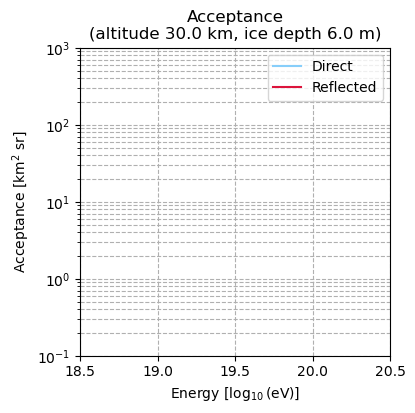

In [3]:
# Plot results
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(E_bins, A_direct, label="Direct", c="lightskyblue", ls="solid")
ax.plot(E_bins, A_reflected, label="Reflected", c="crimson", ls="solid")

ax.set( xlabel=L"Energy [$\log_{10}$(eV)]", 
        ylabel=L"Acceptance [km$^2$ sr]",
        xlim=[18.5, 20.5],
        ylim=[1e-1, 1e3],
        yscale="log", 
        title="Acceptance\n(altitude "*string(altitude)*", ice depth "*string(ice_depth)*")")
ax.set_axisbelow(true)
ax.grid(which="both", linestyle="dashed")
ax.legend()
gcf()  # Shows the figure in the notebook

In [43]:
using CoRaLS
using PyPlot


function test_fresnel_reflection()

    # we test the full range of incident angles
    θ_i = 0:0.2:90

    # use representative values for regolith and ice
    nrego = regolith_index(StrangwayIndex(), 6.0m)
    nice = 1.305

    # make the plot
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(θ_i, [CoRaLS.fresnel_rpar(deg2rad(θ), nrego, nice) for θ in θ_i], label=L"$r_{\parallel}$")
    ax.plot(θ_i, [CoRaLS.fresnel_rperp(deg2rad(θ), nrego, nice) for θ in θ_i], label=L"$r_{\perp}$")
    # ax.axvline(CoRaLS.fresnel_critical(nrego, nice), c="k", ls="dotted", label=L"$\theta_{crit}$")
    ax.axhline(0., c="k", ls="dotted")
    title = LaTeXString("Regolith (n=$(round(nrego,digits=3))) \$\\rightarrow\$ Ice (n=$(nice)) Reflection")
    ax.set(xlabel="Incident Angle (deg)", ylabel="Fresnel Coefficient", title=title)
    ax.set_axisbelow(true)
    ax.grid(which="both", linestyle="dashed")
    ax.legend()

end

function test_fresnel_trans()

    # we test the full range of incident angles
    θ_i = 0:0.2:90

    # use representative values for regolith and ice
    nrego = regolith_index(StrangwayIndex(), 6.0m)
    nice = 1.305

    # make the plot
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(θ_i, [CoRaLS.fresnel_tpar(deg2rad(θ), nrego, nice) for θ in θ_i], label=L"$r_{\parallel}$")
    ax.plot(θ_i, [CoRaLS.fresnel_tperp(deg2rad(θ), nrego, nice) for θ in θ_i], label=L"$r_{\perp}$")
    # ax.axvline(CoRaLS.fresnel_critical(nrego, nice), c="k", ls="dotted", label=L"$\theta_{crit}$")
    ax.axhline(0., c="k", ls="dotted")
    title = LaTeXString("Regolith (n=$(round(nrego,digits=3))) \$\\rightarrow\$ Ice (n=$(nice)) Transmission")
    ax.set(xlabel="Incident Angle (deg)", ylabel="Fresnel Coefficient", title=title)
    ax.set_axisbelow(true)
    ax.grid(which="both", linestyle="dashed")
    ax.legend()

end

function test_fresnel_transmission()

    # use representative values for surface regolith and vacuum
    ni = regolith_index(StrangwayIndex(), 0.0m)
    nt = 1.0

    # calculate the TIR angle
    θ_c = asin(nt / ni)

    # we test the full range of incident angles
    θ_i = deg2rad(0.01):deg2rad(0.05):deg2rad(90.0)

    # make the plot
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(rad2deg.(θ_i), [CoRaLS.fresnel_tpar(θ, ni, nt) for θ in θ_i], label=L"$t_{\parallel}$")
    ax.plot(rad2deg.(θ_i), [CoRaLS.fresnel_tperp(θ, ni, nt) for θ in θ_i], label=L"$t_{\perp}$")
    ax.axhline(0., c="k", ls="dotted")
    title = LaTeXString("Regolith (n=$(round(ni,digits=3))) \$\\rightarrow\$ Vacuum Transmission")

    ax.set(xlabel="Incident Angle (deg)", ylabel="Fresnel Coefficient", title=title)
    ax.set_axisbelow(true)
    ax.grid(which="both", linestyle="dashed")
    ax.legend()

end

function test_divergence_coefficient()

    # use representative values for surface regolith and vacuum
    ni = regolith_index(StrangwayIndex(), 0.0m)
    nt = 1.0

    # calculate the TIR angle
    θ_c = asin(nt / ni)

    # we test the full range of incident angles
    θ_i = deg2rad(0.01):deg2rad(0.05):θ_c

    # make the plot
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(rad2deg.(θ_i), [CoRaLS.divergence_tpar(FarFieldDivergence(), θ_i[i], ni, 6.0m, 25.0km) for i in 1:length(θ_i)],
            label=L"$T_{\parallel}$")
    ax.plot(rad2deg.(θ_i), [CoRaLS.divergence_tperp(FarFieldDivergence(), θ_i[i], ni, 6.0m, 25.0km) for i in 1:length(θ_i)],
            label=L"$T_{\perp}$")
    ax.axvline(rad2deg(θ_c), c="k", ls="dotted")
    ax.set(xlabel="Incident Angle (deg)", ylabel="Fresnel Coefficient w/ Far-Field Divergence", ylim=[0., 1.0],
           title=L"Regolith $\rightarrow$ Vacuum Transmission")
    ax.set_axisbelow(true)
    ax.grid(which="both", linestyle="dashed")
    ax.legend(loc="upper right")

end


test_divergence_coefficient (generic function with 1 method)

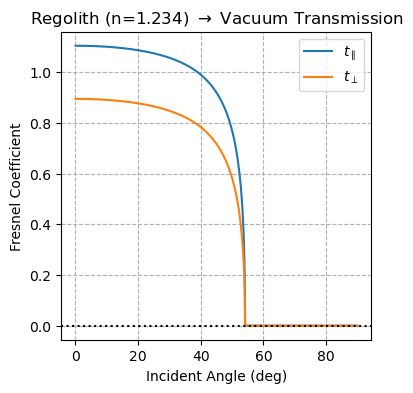

In [45]:
# test_fresnel_reflection()
# test_fresnel_trans()
test_fresnel_transmission()
# test_divergence_coefficient()
gcf()

In [ ]:
import numpy
np.asin()

## Breaking down model components

**Coming soon**